In [319]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
import random

# Preprocessing for NN
from torch.utils.data import TensorDataset, DataLoader, Subset
import random

# NN
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import ParameterGrid, KFold, StratifiedKFold

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [320]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

# define plt and sns styles
sns.set_style("whitegrid")
sns.set_palette("Set2")

In [321]:
df_train = pd.read_csv('data/student-mat-processed.csv')
df_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,1,0,18,0,1,1,4,4,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,17,0,1,0,1,1,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0,15,0,0,0,1,1,1,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,0,15,0,1,0,4,2,1,3,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,0,16,0,1,0,3,3,1,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<Axes: >

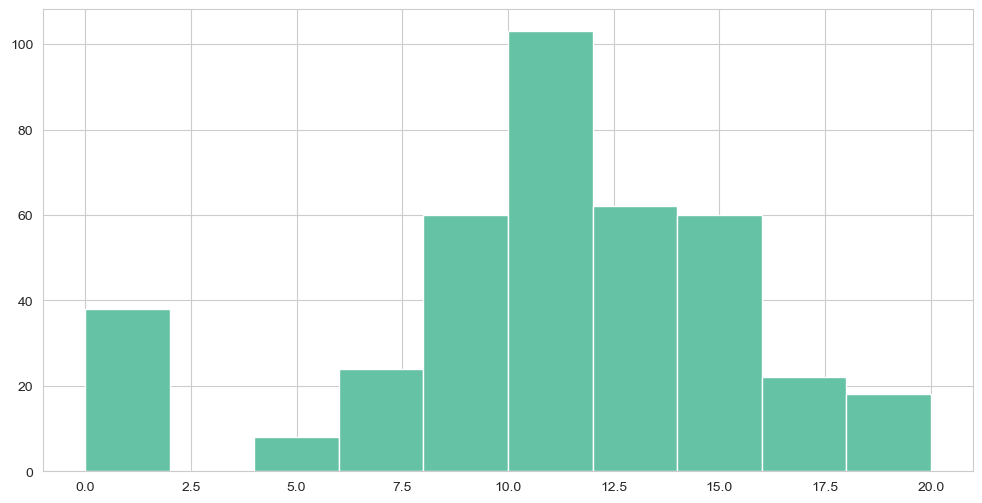

In [322]:
df_train.G3.hist()

In [323]:
df_train.G3.describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

In [324]:
# Splitting of the target column
X_train = df_train.drop(['G1', 'G2', 'G3'], axis=1)
y_train = df_train['G3']

# Binning the target column
bins = [y_train.min(), 4, 9,  11, 13, 15, y_train.max()]
labels = [0, 1, 2, 3, 4, 5]
y_train = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True)

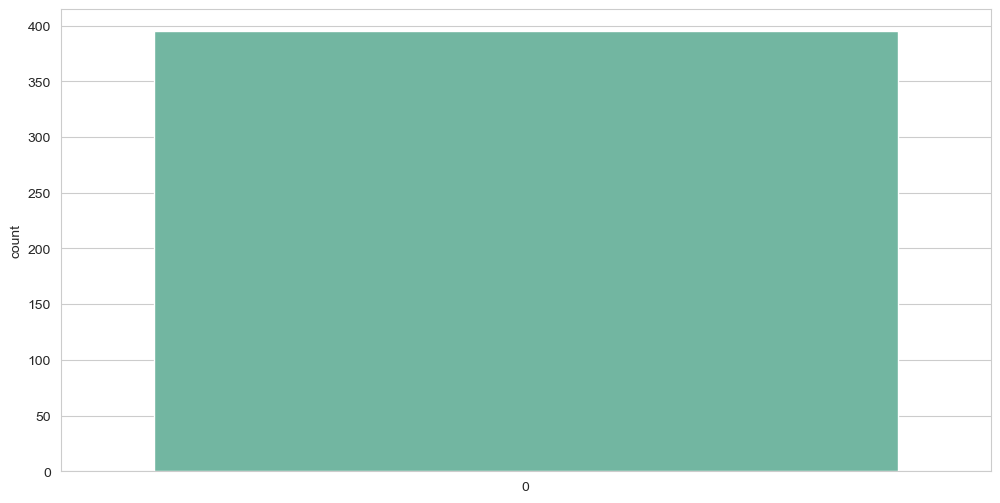

In [325]:
# plot the distribution of the target labels
sns.countplot(y_train)
plt.show()

In [326]:
features = X_train.to_numpy()
labels = y_train.to_numpy()

# Convert arrays to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)  # or torch.long for classification labels

# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## NN Implementation

In [327]:
# different activation functions, number of layers, number of neurons
class BasicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BasicNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.log_softmax(self.layer2(x), dim=1)
        return x

In [328]:
net = BasicNN(input_size=43, hidden_size=60, output_size=6)
print(net)

BasicNN(
  (layer1): Linear(in_features=43, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=6, bias=True)
)


In [329]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [330]:
num_epochs = 10

for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        # Forward pass: Compute predicted y by passing x to the model
        pred_y = net(batch_features)

        # Compute and print loss
        loss = criterion(pred_y, batch_labels.long())  # labels should be of type long for NLLLoss

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [331]:
# Calculate mse with train data
pred_y = net(features_tensor)
loss = criterion(pred_y, labels_tensor.long())
print(loss.item())

1.3549375534057617


In [332]:
_, predicted_labels = torch.max(pred_y, 1)
predicted_labels

tensor([1, 2, 1, 5, 2, 5, 5, 1, 5, 5, 4, 2, 3, 5, 0, 5, 4, 1, 1, 3, 5, 5, 5, 3,
        1, 1, 2, 3, 2, 1, 3, 5, 0, 5, 5, 3, 5, 5, 1, 2, 1, 3, 5, 3, 1, 1, 1, 4,
        3, 5, 3, 5, 3, 3, 3, 2, 5, 4, 3, 5, 3, 1, 1, 1, 3, 5, 3, 1, 1, 3, 4, 5,
        1, 3, 1, 2, 5, 3, 1, 3, 3, 2, 3, 2, 3, 1, 1, 4, 3, 1, 0, 4, 1, 0, 5, 2,
        3, 1, 4, 1, 1, 5, 5, 1, 5, 1, 1, 5, 3, 5, 5, 0, 1, 5, 3, 5, 5, 5, 1, 3,
        3, 2, 3, 1, 0, 3, 3, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 5, 3, 1, 5, 3,
        0, 3, 0, 2, 0, 0, 0, 3, 1, 0, 0, 1, 3, 1, 3, 3, 0, 1, 0, 3, 0, 1, 3, 0,
        0, 4, 0, 3, 5, 0, 1, 3, 2, 3, 3, 3, 3, 5, 3, 1, 3, 3, 3, 3, 4, 2, 3, 0,
        3, 3, 0, 3, 5, 3, 1, 5, 5, 1, 2, 1, 2, 1, 1, 3, 2, 2, 3, 3, 2, 1, 3, 4,
        1, 1, 2, 2, 1, 0, 5, 3, 5, 1, 1, 3, 3, 3, 3, 2, 1, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 0, 5, 0, 1, 3, 1, 1, 3, 0, 2, 1, 0, 3, 1, 4, 5, 2, 3, 3, 5, 3, 2,
        0, 3, 3, 2, 3, 0, 1, 3, 2, 3, 4, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 3, 2, 5,
        4, 5, 3, 4, 1, 3, 5, 2, 0, 1, 4,

##  Flexible NN approach

In [333]:
class FlexibleNN(nn.Module):
    def __init__(self, layer_sizes, activation_fn):
        super(FlexibleNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        self.activation_fn = activation_fn

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply activation function to all but last layer
            x = self.activation_fn(layer(x))
        x = F.log_softmax(self.layers[-1](x), dim=1)  # Last layer with log softmax
        return x

In [334]:
def train_evaluate_model(params, train_loader, val_loader):
    net = FlexibleNN(layer_sizes=params['layer_sizes'], activation_fn=params['activation_fn'])
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=params['lr'])

    num_epochs = 10
    all_losses = []

    for epoch in range(num_epochs):
        for batch_features, batch_labels in train_loader:
            pred_y = net(batch_features)
            loss = criterion(pred_y, batch_labels.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        all_preds = []
        all_labels = []
        for batch_features, batch_labels in val_loader:
            pred_y = net(batch_features)
            all_preds.extend(pred_y.argmax(dim=1).tolist())
            all_labels.extend(batch_labels.tolist())

        # Store the loss for this fold
        all_losses.append(loss.item())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro')
    # calculate a confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Return the average loss over all folds
    avg_loss = sum(all_losses) / len(all_losses)

    return (avg_loss, accuracy, precision, recall, f1), cm

In [335]:
parameters_grid = {
    'layer_sizes': [[43, 20, 10, 6], [43, 30, 10, 6], [43, 30, 20, 10, 6], [43, 40, 30, 20, 10, 6], [43, 50, 20, 10, 6], [43, 100, 50, 20, 10, 6], 
                    [43, 200, 100, 50, 20, 10, 6], [43, 300, 200, 100, 50, 20, 10, 6], [43, 400, 300, 200, 100, 50, 20, 10, 6], [43, 500, 400, 300, 200, 100, 50, 20, 10, 6]],
    'activation_fn': [F.relu, torch.tanh, torch.sigmoid],
    'lr': [0.001, 0.01, 0.1, 0.2, 0.3]
}

## Grid Search

In [336]:
full_start_time = time.time()
skf = StratifiedKFold(n_splits=5)
results = []

# Implementing grid search from scratch
for params in ParameterGrid(parameters_grid):
    all_metrics = []
    all_cm = []
    start_time = time.time()
    labels_np = np.array(labels)

    for train_idx, val_idx in skf.split(np.zeros(len(labels_np)), labels_np):
        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=64)
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=64)
        metrics, cm = train_evaluate_model(params, train_loader, val_loader)
        all_metrics.append(metrics)
        all_cm.append(cm)

    params['activation_fn'] = params['activation_fn'].__name__

    avg_metrics = [sum(metric) / len(metric) for metric in zip(*all_metrics)]
    stacked_cm = np.stack(all_cm, axis=2)
    avg_cm = stacked_cm.mean(axis=2)
    elapsed_time = time.time() - start_time
    results.append({'params': params, 'loss': avg_metrics[0], 'accuracy': avg_metrics[1], 'precision': avg_metrics[2], 'recall': avg_metrics[3], 'f1': avg_metrics[4], 'time': elapsed_time, 'cm': avg_cm})

print("Total time elapsed:", time.time() - full_start_time)

# Saving the results in a DataFrame
df_results = pd.DataFrame(results)

Total time elapsed: 42.006561040878296


params       {'activation_fn': 'tanh', 'layer_sizes': [43, ...
loss                                                  1.544262
accuracy                                              0.331646
precision                                              0.25277
recall                                                0.301536
f1                                                    0.250847
time                                                  0.176258
cm           [[4.4, 0.4, 1.0, 0.2, 1.6, 0.2], [1.6, 7.8, 6....
Name: 61, dtype: object
Best Loss: 1.5442617297172547
Best Params: {'activation_fn': 'tanh', 'layer_sizes': [43, 30, 20, 10, 6], 'lr': 0.01}


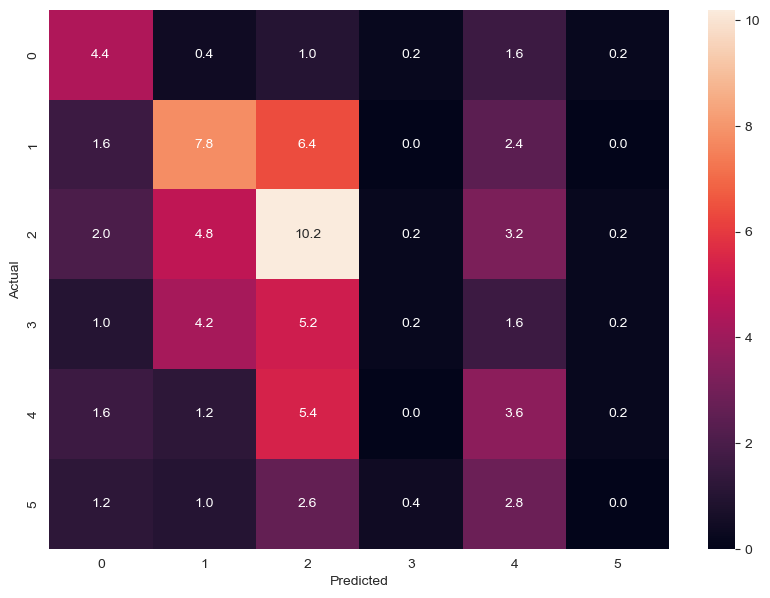

<Figure size 1200x600 with 0 Axes>

In [337]:
best_run = df_results.loc[df_results['loss'].idxmin()]
print(best_run)
print("Best Loss:", best_run['loss'])
print("Best Params:", best_run['params'])
plt.figure(figsize=(10,7))
sns.heatmap(best_run['cm'], annot=True, fmt=".1f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('student_mat_confusion_matrix_grid_search_best.png')

## Random Search

In [338]:
def random_search_from_grid(parameters_grid, num_iterations, dataset):
    skf = StratifiedKFold(n_splits=5)
    results = []

    for _ in range(num_iterations):
        start_time = time.time()
        layer_sizes = random.choice(parameters_grid['layer_sizes'])
        activation_fn = random.choice(parameters_grid['activation_fn'])
        lr = random.choice(parameters_grid['lr'])

        params = {
            'layer_sizes': layer_sizes,
            'activation_fn': activation_fn,
            'lr': lr
        }

        all_metrics = []
        all_cm = []

        labels_np = np.array(labels)

        for train_idx, val_idx in skf.split(np.zeros(len(labels_np)), labels_np):
            train_loader = DataLoader(Subset(dataset, train_idx), batch_size=64)
            val_loader = DataLoader(Subset(dataset, val_idx), batch_size=64)
            metrics, cm = train_evaluate_model(params, train_loader, val_loader)
            all_metrics.append(metrics)
            all_cm.append(cm)

        params['activation_fn'] = params['activation_fn'].__name__

        avg_metrics = [sum(metric) / len(metric) for metric in zip(*all_metrics)]
        stacked_cm = np.stack(all_cm, axis=2)
        avg_cm = stacked_cm.mean(axis=2)


        elapsed_time = time.time() - start_time
        results.append({'params': params, 'loss': avg_metrics[0], 'accuracy': avg_metrics[1], 'precision': avg_metrics[2], 'recall': avg_metrics[3], 'f1': avg_metrics[4], 'time': elapsed_time, 'cm': avg_cm})

        print(f"Loss: {avg_metrics[0]}, Accuracy: {avg_metrics[1]}, Precision: {avg_metrics[2]}, Recall: {avg_metrics[3]}, F1: {avg_metrics[4]}, Params: {params}")

    df_results = pd.DataFrame(results)

    return df_results

full_start_time = time.time()
df_results_random = random_search_from_grid(parameters_grid, 50, dataset)
print(f"Total time: {time.time() - full_start_time}")

Loss: 1.725582482814789, Accuracy: 0.28354430379746837, Precision: 0.09427595978869609, Recall: 0.19748677248677246, F1: 0.11639255580667518, Params: {'layer_sizes': [43, 30, 10, 6], 'activation_fn': 'relu', 'lr': 0.1}
Loss: 1.7225448775291443, Accuracy: 0.27848101265822783, Precision: 0.09937396690206807, Recall: 0.19225981620718463, F1: 0.12536786145411632, Params: {'layer_sizes': [43, 400, 300, 200, 100, 50, 20, 10, 6], 'activation_fn': 'relu', 'lr': 0.001}
Loss: 1.6986196565628053, Accuracy: 0.28607594936708863, Precision: 0.09372472794123066, Recall: 0.19087023113338902, F1: 0.11999808209827234, Params: {'layer_sizes': [43, 20, 10, 6], 'activation_fn': 'sigmoid', 'lr': 0.01}
Loss: 1.7914235615730285, Accuracy: 0.260759493670886, Precision: 0.043459915611814344, Recall: 0.16666666666666666, F1: 0.06893602693602693, Params: {'layer_sizes': [43, 30, 10, 6], 'activation_fn': 'tanh', 'lr': 0.2}
Loss: 1.776669600009918, Accuracy: 0.25569620253164554, Precision: 0.07564102564102564, Reca

params       {'layer_sizes': [43, 30, 10, 6], 'activation_f...
loss                                                  1.560781
accuracy                                              0.331646
precision                                             0.236567
recall                                                0.306201
f1                                                    0.261294
time                                                  0.160883
cm           [[4.6, 0.4, 1.2, 0.0, 1.4, 0.2], [2.2, 9.6, 4....
Name: 7, dtype: object
Best Loss: 1.5607805848121643
Best Params: {'layer_sizes': [43, 30, 10, 6], 'activation_fn': 'tanh', 'lr': 0.01}


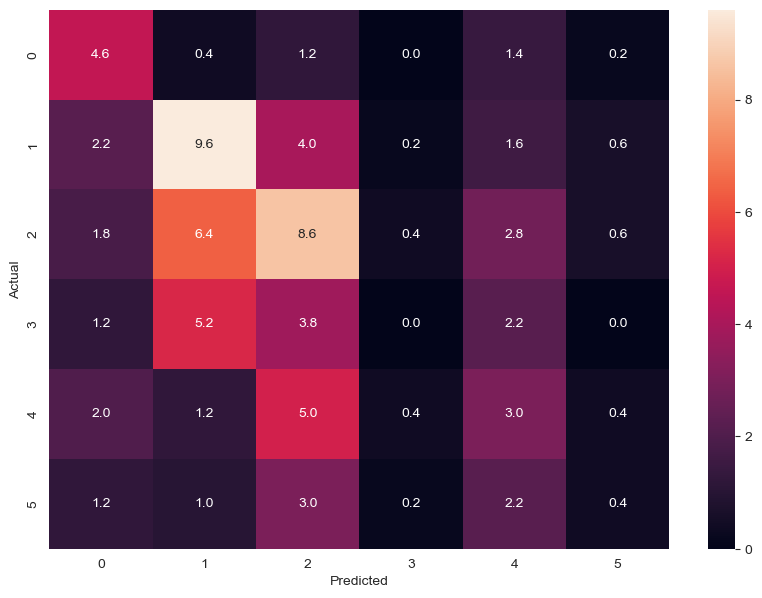

<Figure size 1200x600 with 0 Axes>

In [339]:
best_run = df_results_random.loc[df_results_random['loss'].idxmin()]
print(best_run)
print("Best Loss:", best_run['loss'])
print("Best Params:", best_run['params'])
plt.figure(figsize=(10,7))
sns.heatmap(best_run['cm'], annot=True, fmt=".1f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('student_mat_confusion_matrix_random_search_best.png')

In [340]:
df_results_random.sort_values(by='loss', ascending=True, inplace=True)
df_results_random.head()

,params,loss,accuracy,precision,recall,f1,time,cm
7,"{'layer_sizes': [43, 30, 10, 6], 'activation_f...",1.560781,0.331646,0.236567,0.306201,0.261294,0.160883,"[[4.6, 0.4, 1.2, 0.0, 1.4, 0.2], [2.2, 9.6, 4...."
16,"{'layer_sizes': [43, 30, 10, 6], 'activation_f...",1.620020,0.293671,0.196601,0.242057,0.195448,0.156621,"[[2.6, 0.4, 4.0, 0.0, 0.8, 0.0], [1.4, 6.8, 9...."
37,"{'layer_sizes': [43, 50, 20, 10, 6], 'activati...",1.634858,0.275949,0.144476,0.204147,0.162118,0.174165,"[[0.0, 0.8, 5.0, 0.0, 1.2, 0.8], [0.0, 7.0, 8...."
38,"{'layer_sizes': [43, 30, 20, 10, 6], 'activati...",1.676089,0.303797,0.159538,0.226136,0.159947,0.169903,"[[0.0, 0.4, 4.6, 0.0, 2.8, 0.0], [0.0, 5.4, 10..."
10,"{'layer_sizes': [43, 30, 10, 6], 'activation_f...",1.688960,0.288608,0.116553,0.218545,0.138420,0.156715,"[[0.0, 0.2, 4.4, 0.0, 3.2, 0.0], [0.0, 7.0, 9...."


## Evaluation of Results

In [341]:
# save a copy of the results dataframe in another df
df_results_random_copy = df_results_random.copy()
df_results_copy = df_results.copy()

In [342]:
df_results_random = df_results_random_copy.copy()
df_results = df_results_copy.copy()

In [343]:
df_results['search_method'] = 'grid_search'
df_results_random['search_method'] = 'random_search'

df_results = pd.concat([df_results.drop(['params'], axis=1), df_results['params'].apply(pd.Series)], axis=1)

df_results_random = pd.concat([df_results_random.drop(['params'], axis=1), df_results_random['params'].apply(pd.Series)], axis=1)

df_result = pd.concat([df_results, df_results_random], axis=0)
df_result.head()

,loss,accuracy,precision,recall,f1,time,cm,search_method,activation_fn,layer_sizes,lr
0,1.728930,0.273418,0.121646,0.188844,0.111929,0.203846,"[[0.4, 0.8, 6.6, 0.0, 0.0, 0.0], [0.0, 7.0, 11...",grid_search,relu,"[43, 20, 10, 6]",0.001
1,1.588563,0.311392,0.198781,0.253772,0.212657,0.153750,"[[1.6, 0.2, 3.2, 0.2, 2.0, 0.6], [0.8, 7.0, 7....",grid_search,relu,"[43, 20, 10, 6]",0.010
2,1.682531,0.273418,0.106681,0.211561,0.121348,0.154463,"[[1.2, 0.0, 5.2, 0.0, 1.4, 0.0], [0.8, 1.0, 14...",grid_search,relu,"[43, 20, 10, 6]",0.100
3,1.745501,0.260759,0.043460,0.166667,0.068936,0.156658,"[[0.0, 0.0, 7.8, 0.0, 0.0, 0.0], [0.0, 0.0, 18...",grid_search,relu,"[43, 20, 10, 6]",0.200
4,1.820362,0.253165,0.042194,0.166667,0.067307,0.153888,"[[0.0, 1.6, 6.2, 0.0, 0.0, 0.0], [0.0, 3.6, 14...",grid_search,relu,"[43, 20, 10, 6]",0.300


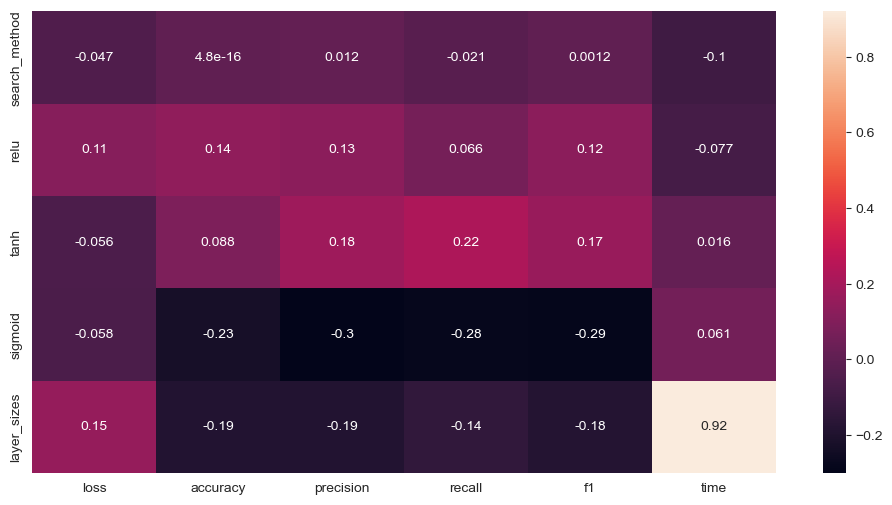

In [344]:
# mapping search
# 0: grid_search
# 1: random_search

# mapping activation_fn
# 0: relu
# 1: tanh
# 2: sigmoid

df_correlation = df_result.copy()

df_correlation.drop(['cm'], axis=1, inplace=True)

df_correlation['search_method'] = df_correlation['search_method'].map({'grid_search': 0, 'random_search': 1})
df_correlation['activation_fn'] = df_correlation['activation_fn'].map({'relu': 0, 'tanh': 1, 'sigmoid': 2})
df_correlation['layer_sizes'] = df_correlation['layer_sizes'].apply(lambda x: len(x))
df_correlation['relu'] = df_correlation['activation_fn'].apply(lambda x: 1 if x == 0 else 0)
df_correlation['tanh'] = df_correlation['activation_fn'].apply(lambda x: 1 if x == 1 else 0)
df_correlation['sigmoid'] = df_correlation['activation_fn'].apply(lambda x: 1 if x == 2 else 0)

corr = df_correlation.corr()

corr_subset = corr.loc[['search_method', 'relu' , 'tanh', 'sigmoid', 'layer_sizes'],
                       ['loss', 'accuracy', 'precision', 'recall', 'f1', 'time']]

# Create a heatmap of the subset
sns.heatmap(corr_subset, annot=True)
plt.show()
plt.show()

### Trade-off between metrics

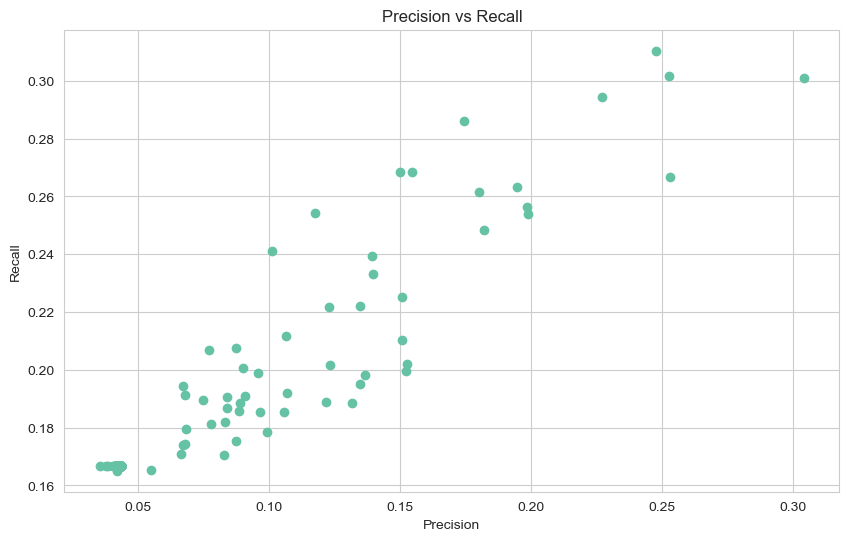

<Figure size 1200x600 with 0 Axes>

In [345]:
# Usually higher precision comes at the cost of lower recall and vice versa, 
# but in this case we can see that the model with the highest precision also has the highest recall. 
# This is because the model with the highest precision and recall is the model with the highest accuracy, 
# which is the model with the highest F1 score. This means that the model with the highest F1 score is the best model.

plt.figure(figsize=(10, 6))
plt.scatter(df_results['precision'], df_results['recall'])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall')
plt.show()
plt.savefig('student_mat_precision_vs_recall_grid_search.png')

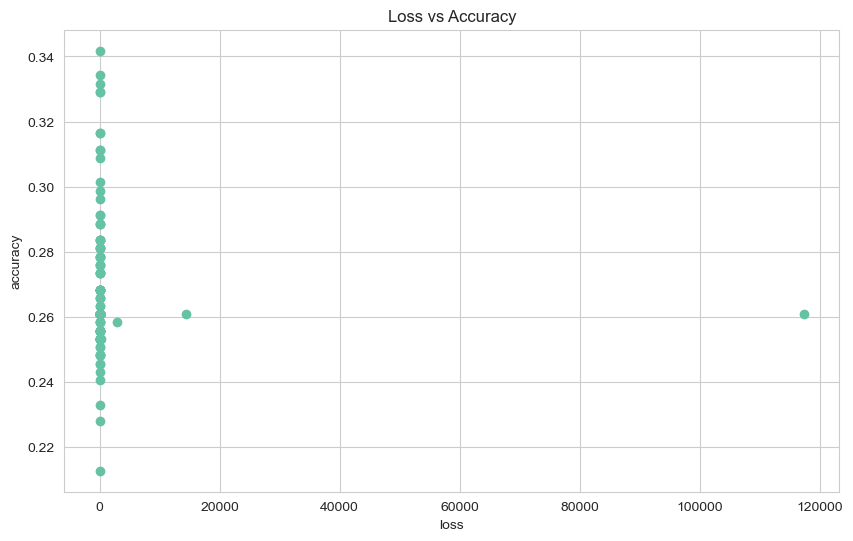

<Figure size 1200x600 with 0 Axes>

In [346]:
plt.figure(figsize=(10, 6))
plt.scatter(df_results['loss'], df_results['accuracy'])
plt.xlabel('loss')
plt.ylabel('accuracy')
plt.title('Loss vs Accuracy')
plt.show()
plt.savefig('student_mat_loss_vs_accuracy.png')

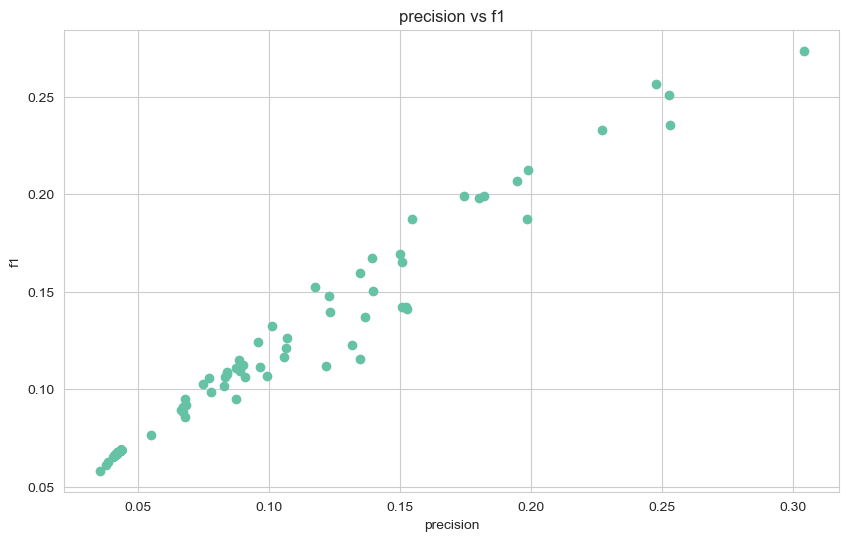

<Figure size 1200x600 with 0 Axes>

In [347]:
plt.figure(figsize=(10, 6))
plt.scatter(df_results['precision'], df_results['f1'])
plt.xlabel('precision')
plt.ylabel('f1')
plt.title('precision vs f1')
plt.show()
plt.savefig('student_mat_precision_vs_f1.png')

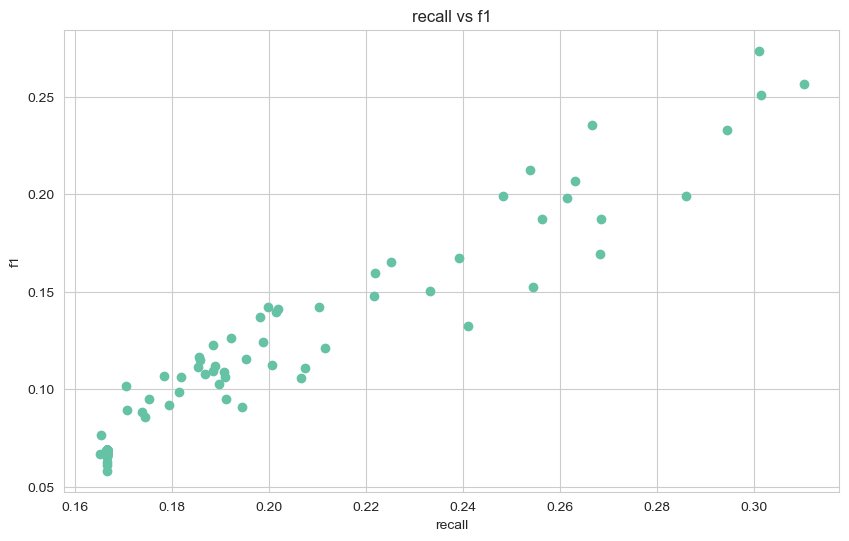

<Figure size 1200x600 with 0 Axes>

In [348]:
plt.figure(figsize=(10, 6))
plt.scatter(df_results['recall'], df_results['f1'])
plt.xlabel('recall')
plt.ylabel('f1')
plt.title('recall vs f1')
plt.show()
plt.savefig('student_mat_recall_vs_f1.png')

### Logistic Regression

In [349]:
def train_evaluate_logistic_regression(train_features, train_labels, val_features, val_labels):
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
    model.fit(train_features, train_labels)
   
    #Predictions on the validation set
    predictions = model.predict(val_features)
   
    #Evaluation metrics
    accuracy = accuracy_score(val_labels, predictions)
    precision = precision_score(val_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(val_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(val_labels, predictions, average='macro')
    cm = confusion_matrix(val_labels, predictions)
   
    return accuracy, precision, recall, f1, cm

lr_metrics = []

#Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5)

# Initialize the results DataFrame
results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "Runtime"])

for fold, (train_index, val_index) in enumerate(skf.split(features, labels)):
    X_train, X_val = features[train_index], features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    #Train and evaluate the logistic regression classifier
    start_time = time.time()
    lr_accuracy, lr_precision, lr_recall, lr_f1, lr_cm = train_evaluate_logistic_regression(X_train, y_train, X_val, y_val)
    end_time = time.time()
    runtime = end_time - start_time

    #Results
    results.loc[fold] = [lr_accuracy, lr_precision, lr_recall, lr_f1, runtime]
    lr_metrics.append([lr_accuracy, lr_precision, lr_recall, lr_f1])
    
print("Default Logistic Regression Results:")
print(results)

Default Logistic Regression Results:
   Accuracy  Precision    Recall        F1   Runtime
0  0.291139   0.316982  0.292627  0.286347  0.018160
1  0.367089   0.368122  0.402116  0.362834  0.016409
2  0.253165   0.368697  0.272156  0.294836  0.013468
3  0.253165   0.249899  0.213294  0.210589  0.012883
4  0.265823   0.282672  0.241524  0.235657  0.010508


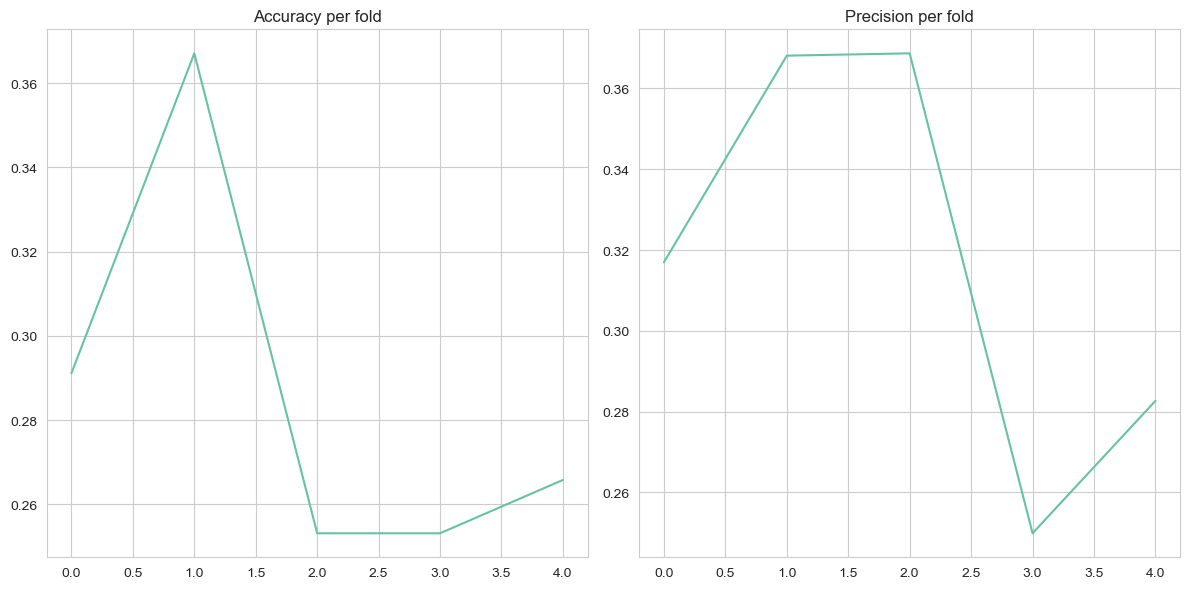

In [350]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results.index, results['Accuracy'], label='Accuracy')
plt.title('Accuracy per fold')

plt.subplot(1, 2, 2)
plt.plot(results.index, results['Precision'], label='Precision')
plt.title('Precision per fold')

plt.tight_layout()
plt.show()

In [351]:
avg_lr_metrics = np.mean(lr_metrics, axis=0)
# Display average metrics
print("Average Metrics for Logistic Regression:")
print("Accuracy:", avg_lr_metrics[0])
print("Precision:", avg_lr_metrics[1])
print("Recall:", avg_lr_metrics[2])
print("F1 Score:", avg_lr_metrics[3])

Average Metrics for Logistic Regression:
Accuracy: 0.28607594936708863
Precision: 0.3172744885833121
Recall: 0.28434355118565646
F1 Score: 0.27805269507307045


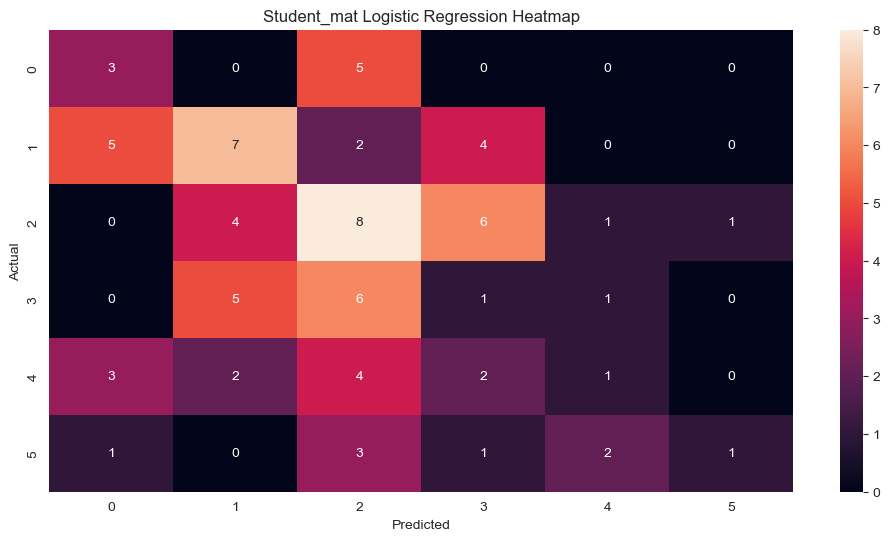

<Figure size 1200x600 with 0 Axes>

In [352]:
sns.heatmap(lr_cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Student_mat Logistic Regression Heatmap')
plt.show()
plt.savefig('student_mat_lr_confusion.png')

### Tabnet model

In [353]:
# Assume df_train is your DataFrame and 'G3' is your target variable
X = df_train.drop('G3', axis=1)
y = df_train['G3']

# Define the evaluation function
def evaluate_model(model, X_val, y_val):
    all_preds = []
    all_labels = []
    pred_y = model.predict(X_val)
    all_preds.extend(pred_y.tolist()) # Change this line
    all_labels.extend(y_val.tolist())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, precision, recall, f1, cm

tabnet_metrics = []

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5)

# Initialize the results DataFrame
results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "Runtime"])

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
 # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# Convert Pandas DataFrames to NumPy arrays
    X_train = X_train.to_numpy()
    X_val = X_val.to_numpy()
    y_train = y_train.to_numpy()
    y_val = y_val.to_numpy()
 

 # Train the TabNet model
    start_time = time.time()
    tabnet = TabNetClassifier()
    tabnet.fit(X_train, y_train)
    end_time = time.time()
    runtime = end_time - start_time

 # Train and evaluate the TabNet model
    tabnet_accuracy, tabnet_precision, tabnet_recall, tabnet_f1 = evaluate_model(tabnet, X_val, y_val)[:4]
    tabnet_cm = confusion_matrix(y_val, tabnet.predict(X_val))

 # Store the results
    results.loc[fold] = [tabnet_accuracy, tabnet_precision, tabnet_recall, tabnet_f1, runtime]
    tabnet_metrics.append([tabnet_accuracy, tabnet_precision, tabnet_recall, tabnet_f1])

avg_tabnet_metrics = np.mean(tabnet_metrics, axis=0)


/Users/gretagyori/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/gretagyori/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/gretagyori/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/gretagyori/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/gretagyori/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/Users/gretagyori/anaconda3/lib/py

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

In [354]:
# Print the results
print("\nAverage Metrics for TabNet:")
print("Accuracy:", avg_tabnet_metrics[0])
print("Precision:", avg_tabnet_metrics[1])
print("Recall:", avg_tabnet_metrics[2])
print("F1 Score:", avg_tabnet_metrics[3])
print("Confusion Matrix:\n", tabnet_cm)


Average Metrics for TabNet:
Accuracy: 0.058227848101265835
Precision: 0.01839567625566105
Recall: 0.05434069334804629
F1 Score: 0.020844402815654476
Confusion Matrix:
 [[0 0 3 0 0 0 1 0 0 0 0 1 0 0 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 1 0 0 0 0 0 0 0 1 2 0]
 [0 0 3 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 3 0 0 0 3 0 0 1 0 0 0 0 4 0 0]
 [0 0 2 0 0 0 6 0 0 0 0 0 0 0 2 0 0]
 [0 0 2 0 0 0 3 0 0 0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 2 1 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 4 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]


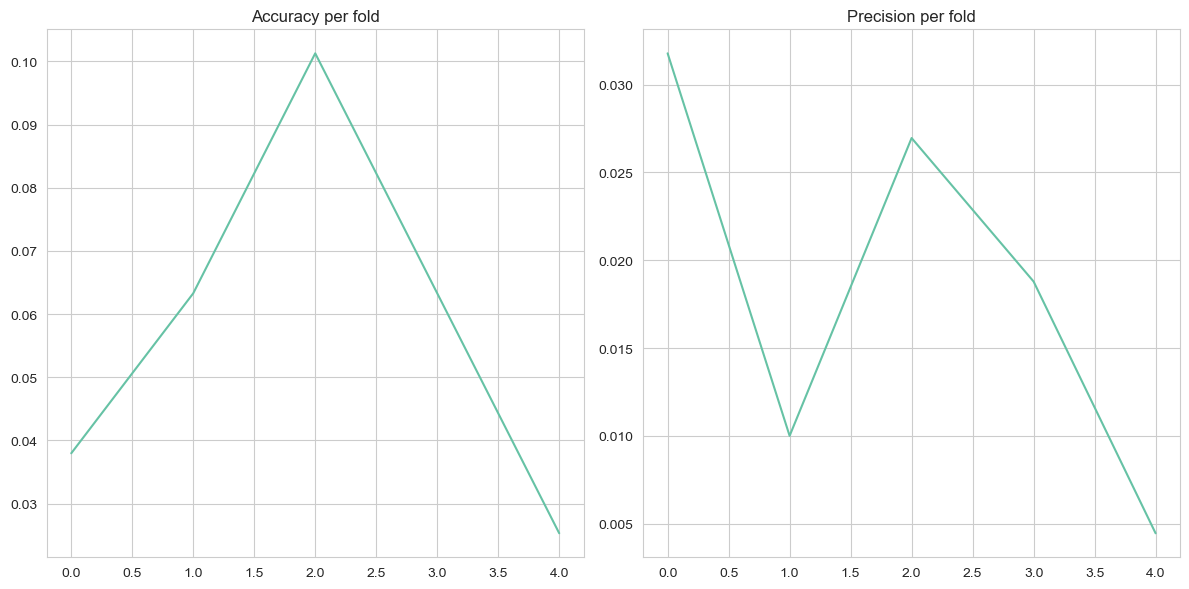

In [355]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results.index, results['Accuracy'], label='Accuracy')
plt.title('Accuracy per fold')

plt.subplot(1, 2, 2)
plt.plot(results.index, results['Precision'], label='Precision')
plt.title('Precision per fold')

plt.tight_layout()
plt.show()

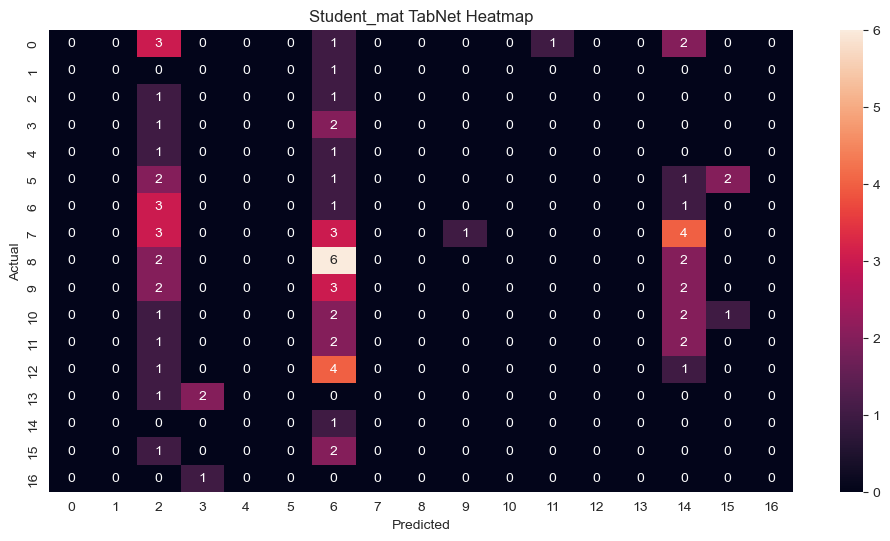

<Figure size 1200x600 with 0 Axes>

In [356]:
sns.heatmap(tabnet_cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Student_mat TabNet Heatmap')
plt.show()
plt.savefig('student_mat_tabnet_confusion.png')

### Overall Comparison

In [357]:
all_metrics = []

lr_metrics = ['Logistic Regression'] + avg_lr_metrics.tolist()
all_metrics.append(lr_metrics)

tabnet_metrics = ['TabNet'] + avg_tabnet_metrics.tolist()
all_metrics.append(tabnet_metrics)

grid_search_metrics = ['Grid Search'] + df_results.sort_values(by='loss').head(1).values.tolist()[0][1:5]
all_metrics.append(grid_search_metrics)

random_search_metrics = ['Random Search'] + df_results_random.sort_values(by='loss').head(1).values.tolist()[0][1:5]
all_metrics.append(random_search_metrics)

columns = ['Implementation', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
df_all_metrics = pd.DataFrame(all_metrics, columns=columns)

print(df_all_metrics)

        Implementation  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.286076   0.317274  0.284344  0.278053
1               TabNet  0.058228   0.018396  0.054341  0.020844
2          Grid Search  0.331646   0.252770  0.301536  0.250847
3        Random Search  0.331646   0.236567  0.306201  0.261294


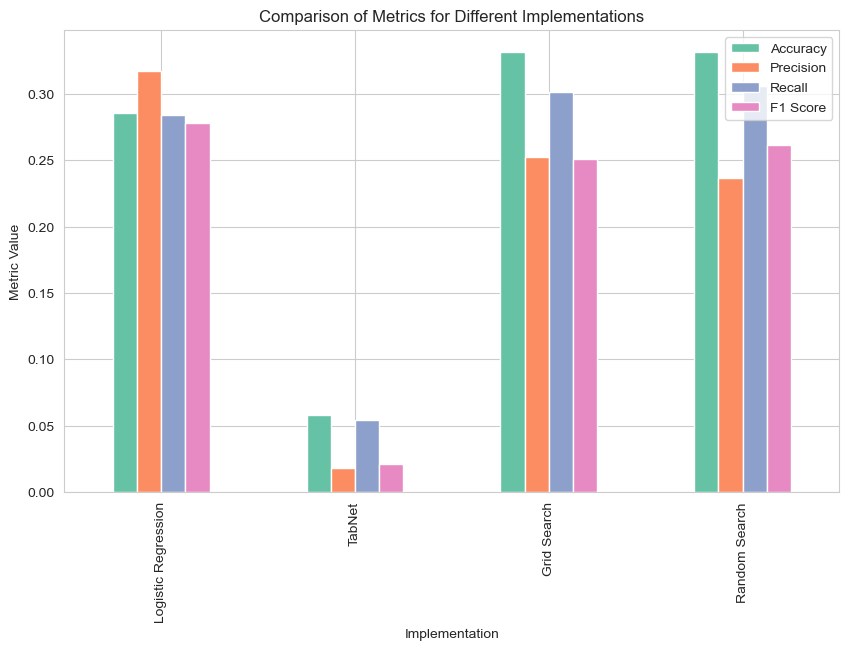

<Figure size 1200x600 with 0 Axes>

In [358]:
# Set the Implementation column as the index
df_all_metrics.set_index('Implementation', inplace=True)

df_all_metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Metrics for Different Implementations')
plt.ylabel('Metric Value')
plt.xlabel('Implementation')
plt.show()
plt.savefig('student_mat_all_barplot.png')

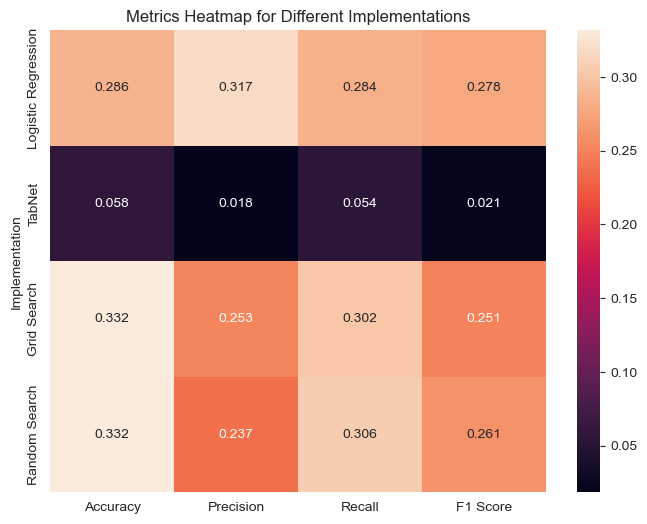

<Figure size 1200x600 with 0 Axes>

In [359]:
# Plot a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(df_all_metrics, annot=True, fmt=".3f")
plt.title('Metrics Heatmap for Different Implementations')
plt.show()
plt.savefig('student_mat_all_heatmap.png')